<a href="https://colab.research.google.com/github/Ciph3r007/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network (GAN)

In [ ]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.transform import resize
import tarfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations, layers, losses, optimizers, regularizers

In [ ]:
def progress(iterable, every=1):
    for index, item in enumerate(iterable):
        if index % every == 0: print("*", end="")
        yield item
    print(".")

def read_images(arch_path, crop_x=80, crop_y=80, size_x=90, size_y=90):
    with tarfile.open(arch_path) as arch:
        for entry in arch.getmembers():
            if entry.isfile() and entry.name.endswith(".jpg"):
                image = plt.imread(arch.extractfile(entry))
                image = image[crop_x : -crop_x, crop_y : -crop_y, : ]
                image = resize(image, (size_x, size_y))
                yield image

In [ ]:
lfw_url = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
lfw_path = "lfw-deepfunneled.tgz"

keras.utils.get_file(lfw_path, lfw_url, cache_dir=".", cache_subdir="")

print("Extracting images: ", end="")
data = np.float32([ image for image in progress(read_images(lfw_path, size_x=36, size_y=36), every=200) ])

108765184/108761145 [==============================] - 72s 1us/step
Extracting images:*******************************************************************.


Image shape : (36, 36, 3)
Total images: 13233


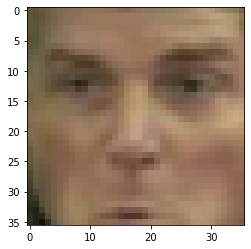

In [ ]:
IMAGE_SHAPE = data.shape[1 : ]

print("Image shape :", IMAGE_SHAPE)
print("Total images:", len(data))

plt.imshow(data[ np.random.randint(len(data)) ])

In [ ]:
CODE_SIZE = 256

def create_generator():
    return keras.Sequential([
        layers.Input(shape=(CODE_SIZE,), name="code"),
        layers.Dense(6 * 6 * 32, activation="elu"),
        layers.Reshape(target_shape=(6, 6, 32)),
        layers.Conv2DTranspose(128, kernel_size=5, activation="elu"),
        layers.Conv2DTranspose(128, kernel_size=3, activation="elu"),
        layers.Conv2DTranspose( 64, kernel_size=3, activation="elu"),
        layers.UpSampling2D(),
        layers.Conv2DTranspose( 64, kernel_size=3, activation="elu"),
        layers.Conv2DTranspose( 32, kernel_size=3, activation="elu"),
        layers.Conv2DTranspose( 32, kernel_size=3, activation="elu"),
        
        layers.Conv2DTranspose(  3, kernel_size=3, name="generated"),
    ], name = "generator")

In [ ]:
def create_discriminator():
    return keras.Sequential([
        layers.Input(shape=IMAGE_SHAPE, name="image"),
        layers.Conv2D( 32, kernel_size=3, activation="elu"),
        layers.Conv2D( 32, kernel_size=5, activation="elu"),
        layers.Conv2D( 64, kernel_size=3, activation="elu"),
        layers.MaxPool2D(),
        layers.Conv2D( 64, kernel_size=3, activation="elu"),
        layers.Conv2D(128, kernel_size=5, activation="elu"),
        layers.Conv2D(128, kernel_size=3, activation="elu"),
        layers.Flatten(),
        layers.Dense(256, activation="tanh", kernel_regularizer=regularizers.l2()),
        layers.Dense(1, activation="sigmoid")
    ], name="discriminator")

In [ ]:
keras.backend.clear_session()

In [ ]:
gen = create_generator()
gen.summary()
print("Inputs :", gen.inputs)
print("Outputs:", gen.outputs)

assert gen.output_shape[1 : ] == IMAGE_SHAPE, "Generator produces output shape {} instead of {}".format(generator.output_shape[1 : ], IMAGE_SHAPE)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1152)              296064    
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       102528    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 128)       147584    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 30, 30, 64)        36

In [ ]:
disc = create_discriminator()

disc.summary()
print("Inputs :", disc.inputs)
print("Outputs:", disc.outputs)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 34, 34, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 128)       

In [ ]:
def create_discriminator_loss(g, d):
    return lambda images, codes: -tf.math.reduce_mean(
        tf.math.log( d(images) ) + tf.math.log( 1 - d(g(codes)) )
    )

def create_generator_loss(g, d):
    return lambda codes: -tf.math.reduce_mean(tf.math.log( d(g(codes)) ))

In [ ]:
disc_opt = optimizers.SGD(1e-3)
disc_loss = create_discriminator_loss(gen, disc)

gen_opt = optimizers.Adam(1e-4)
gen_loss = create_generator_loss(gen, disc)

In [ ]:
def sample_codes(batch_size):
    return np.float32(np.random.normal(size=(batch_size, CODE_SIZE)))

def sample_images(batch_size):
    return data[ np.random.choice(len(data), size=batch_size) ]

def plot_images(nrow, ncol):
    preds = gen.predict(sample_codes(nrow * ncol))

    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(preds[i].clip(0., 1.), interpolation="none")
        plt.axis("off")
    plt.show()

def plot_probas(size):
    plt.hist(disc.predict(sample_images(size)),
        range=(0, 1), alpha=0.5, label="D(x)"
    )
    plt.hist(disc.predict(gen.predict(sample_codes(size))),
        range=(0, 1), alpha=0.5, label="D(G(x))"
    )
    plt.legend()
    plt.show()

In [ ]:
# Uncomment these if you want to save your checkpoints in Google Drive
# from google.colab import drive
# drive.mount("/content/drive")
# os.chdir("/content/drive/My Drive")

In [ ]:
epoch = tf.Variable(0)

ckpt = tf.train.Checkpoint(epoch=epoch, disc=disc, gen=gen, disc_opt=disc_opt, gen_opt=gen_opt)
manager = tf.train.CheckpointManager(ckpt, directory="./checkpoints", max_to_keep=10)

status = ckpt.restore(manager.latest_checkpoint)

Repeat this cell as many times as you can stomach:

Epoch: 29900


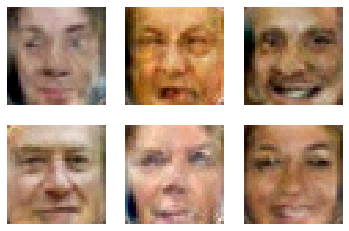

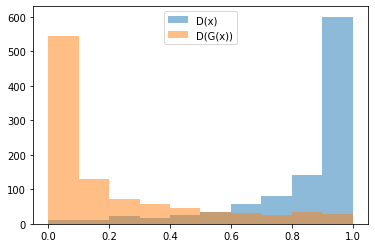

***************************************************************************************************.


In [ ]:
for _ in progress(range(1000)):
    codes = sample_codes(100)
    images = sample_images(100)

    for n in range(5):
        disc_opt.minimize(lambda: disc_loss(images, codes), disc.trainable_weights)

    gen_opt.minimize(lambda: gen_loss(codes), gen.trainable_weights)

    if epoch.numpy() % 100 == 0:
        display.clear_output(wait=True)

        print("Epoch:", epoch.numpy())
        plot_images(2, 3)
        plot_probas(1000)
        manager.save()

    epoch.assign_add(1)

Results after 30000 epochs:


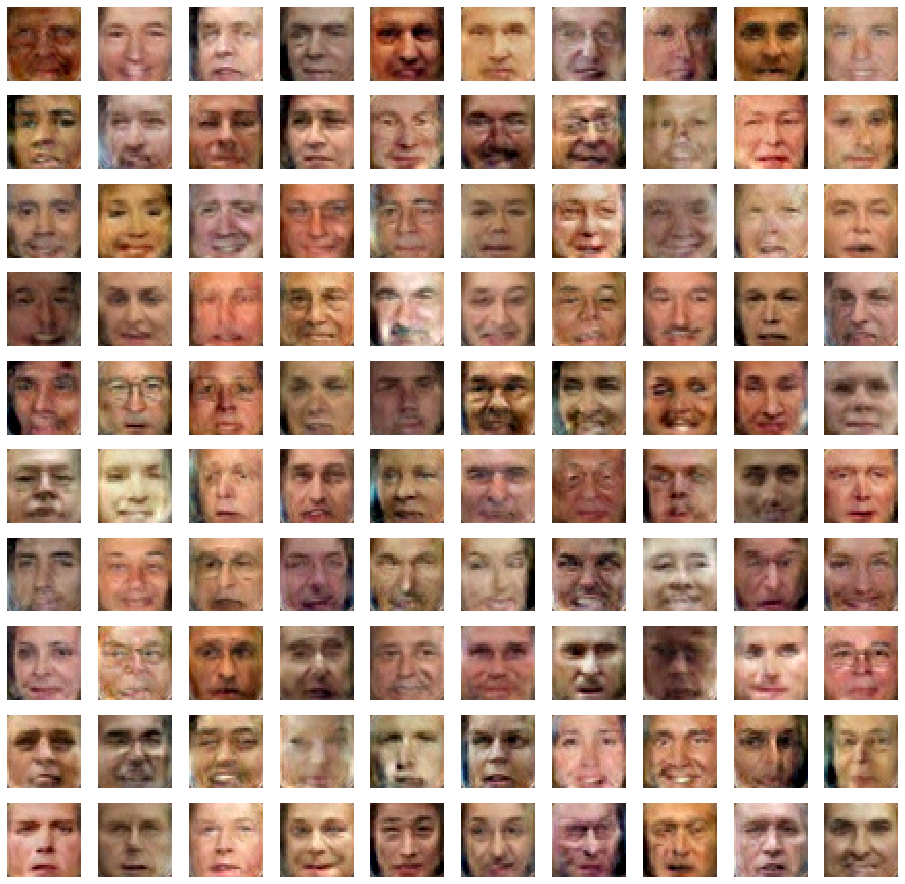

In [ ]:
print("Results after", epoch.numpy(), "epochs:")
plt.figure(figsize=[16, 16])
plot_images(10, 10)